In [1]:
import numpy as np
import pandas as pd

# Setup MLFlow server on my AWS cloud

---
- Create S3 bucket
- Create EC2 instance
- Update EC2 instace's security group inbound rule {"type":"Custom TCP", "Port range": 5000, "CIDR Blocks": "0.0.0.0/0"} -> SAVE 
- Go inside instance terminal
Run Following Code:
```
sudo apt update

sudo apt install python3-pip

sudo apt install pipenv

sudo apt install virtualenv

mkdir mlflow

cd mlflow

pipenv install mlflow

pipenv install awscli

pipenv install boto3

pipenv shell

## Then set aws credentials
aws configure

## run the nuclear fix (anti-DNS-rebind firewall override):

`
mlflow server \ --backend-store-uri sqlite:///mlflow.db \ --default-artifact-root s3://<your-bucket-name> \ --host 0.0.0.0 \ --port 5000 \ --allowed-hosts "*"
`

## Open your MLFlow:

(ec2-13-221-127-40.compute-1.amazonaws.com is your **Public IPv4 DNS**)

http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/

```
---

In [2]:
# Test mlflow

import mlflow

mlflow.set_tracking_uri("http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/")

with mlflow.start_run():
    mlflow.log_param("param1", 15)
    mlflow.log_metric("metric1", 0.89)

2025/12/11 16:23:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run intelligent-jay-728 at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/0/runs/3b695ba0f8354ba681ce71722814ad6a.
2025/12/11 16:23:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/0.


In [3]:
#creating baseline model

import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [5]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df = df[~(df['clean_comment'].str.strip() == '')]
df.shape

(36793, 2)

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vegad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vegad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [10]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [11]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [13]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
y

0        1
1        1
2       -1
3        0
4        1
        ..
37244    0
37245    1
37246    0
37247    1
37248    0
Name: category, Length: 36793, dtype: int64

In [16]:
X.shape

(36793, 10000)

In [17]:
y.shape

(36793,)

In [20]:
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/")

In [21]:
# Set or create an experiment
mlflow.set_experiment("yt-sentiments-classification")

2025/12/11 16:52:10 INFO mlflow.tracking.fluent: Experiment with name 'yt-sentiments-classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-bucket-youtube-sentiments-classifier/1', creation_time=1765452129072, experiment_id='1', last_update_time=1765452129072, lifecycle_stage='active', name='yt-sentiments-classification', tags={}>

2025/12/11 17:14:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/11 17:15:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_Baseline_TrainTestSplit at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/1/runs/fbb328c37db04af6ac737e073e6c4e3b.
2025/12/11 17:15:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-13-221-127-40.compute-1.amazonaws.com:5000/#/experiments/1.


Accuracy: 0.6479141187661367


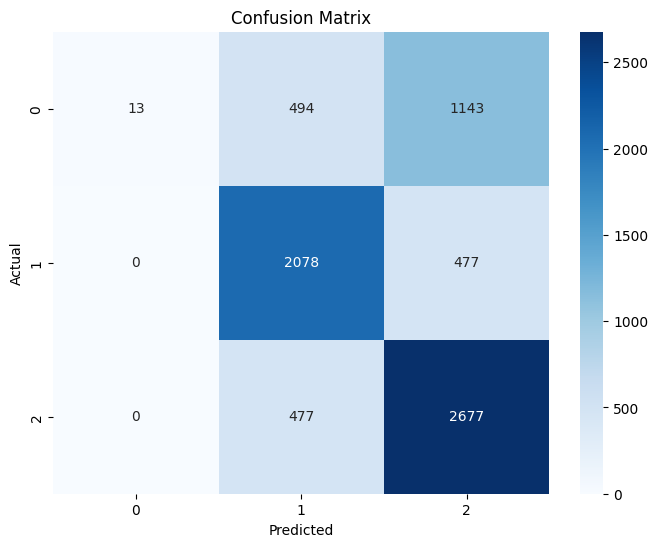

In [24]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1650
           0       0.68      0.81      0.74      2555
           1       0.62      0.85      0.72      3154

    accuracy                           0.65      7359
   macro avg       0.77      0.56      0.49      7359
weighted avg       0.73      0.65      0.57      7359



In [26]:
df.to_csv('reddit_preprocessing.csv', index=False)

In [27]:
pd.read_csv('reddit_preprocessing.csv').head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1
